In [1]:
from dataset import BPI2012Dataset
from parameters.dataset import BPI2012Parameters
from utils.save import get_json_dict
from parameters.training import TrainingParameters, LossParameters, OptimizerParameters
from utils.bpi2012 import remove_trail_steps, print_model_prediction_result, remove_tags_for_seq
from parameters.model import PredNextBERTParameters
from model import PredNextBERT
from controller import TrainingController
from utils.print import print_block
import tensorflow as tf

In [2]:
bpi_2012_parms = BPI2012Parameters()

In [3]:
get_json_dict(bpi_2012_parms)

{'file_path': './data/event_logs/BPI_Challenge_2012.xes',
 'preprocessed_folder_path': './data/preprocessed/BPI_Challenge_2012_with_resource',
 'include_types': ['A', 'O', 'W'],
 'include_complete_only': True}

In [4]:
dataset = BPI2012Dataset(bpi_2012_parms)


| Preprocessed data loaded successfully: ./data/preprocessed/BPI_Challenge_2012_with_resource/AOW_CompleteOnly 


In [5]:
model = PredNextBERT.load(
"./SavedModels/%s"%("0.7876_PredNextBERT_AOW_CompleteOnly_2021-07-04 06:28:09.605710")
)


| Model parameters loaded successfully from: ./SavedModels/0.7876_PredNextBERT_AOW_CompleteOnly_2021-07-04 06:28:09.605710  

| Vocab loaded successfully from: ./SavedModels/0.7876_PredNextBERT_AOW_CompleteOnly_2021-07-04 06:28:09.605710  

| Model loaded successfully from: ./SavedModels/0.7876_PredNextBERT_AOW_CompleteOnly_2021-07-04 06:28:09.605710  


In [6]:
trace_idx = 52
_, example_activities, _, example_resources, example_amount, _ = dataset.collate_fn([trace_idx])
print_block(dataset.activity_vocab.list_of_index_to_vocab_2d(example_activities),"Activity")
print_block(dataset.resource_vocab.list_of_index_to_vocab_2d(example_resources),"Resource")


====================Activity====================
| [['<SOS>', 'A_SUBMITTED_COMPLETE', 'A_PARTLYSUBMITTED_COMPLETE', 'A_PREACCEPTED_COMPLETE', 'W_Completeren aanvraag_COMPLETE', 'W_Completeren aanvraag_COMPLETE', 'A_ACCEPTED_COMPLETE', 'A_FINALIZED_COMPLETE', 'O_SELECTED_COMPLETE', 'O_CREATED_COMPLETE', 'O_SENT_COMPLETE', 'W_Completeren aanvraag_COMPLETE', 'O_SENT_BACK_COMPLETE', 'W_Nabellen offertes_COMPLETE', 'O_ACCEPTED_COMPLETE', 'A_APPROVED_COMPLETE', 'A_REGISTERED_COMPLETE', 'A_ACTIVATED_COMPLETE', 'W_Valideren aanvraag_COMPLETE']] 

====================Resource====================
| [['<SOS>', '112', '112', '112', '11180', '11201', '11201', '11201', '11201', '11201', '11201', '11201', '11049', '11049', '10629', '10629', '10629', '10629', '10629']] 


In [7]:
## Remove tails
tail_length_to_remove = 12
example_idx_activities, example_idx_resources = remove_trail_steps(example_activities, example_resources, tail_length_to_remove)
example_vocab_activities = dataset.activity_vocab.list_of_index_to_vocab_2d(example_idx_activities)[0]
example_vocab_resources = dataset.resource_vocab.list_of_index_to_vocab_2d(example_idx_resources)[0]
print_block(example_vocab_activities, "Activity (Tail removed)")
print_block(example_vocab_resources, "Resource (Tail removed)")


====================Activity (Tail removed)====================
| ['<SOS>', 'A_SUBMITTED_COMPLETE', 'A_PARTLYSUBMITTED_COMPLETE', 'A_PREACCEPTED_COMPLETE', 'W_Completeren aanvraag_COMPLETE', 'W_Completeren aanvraag_COMPLETE', 'A_ACCEPTED_COMPLETE'] 

====================Resource (Tail removed)====================
| ['<SOS>', '112', '112', '112', '11180', '11201', '11201'] 


In [9]:
##### Prepare input
example_activities_input = tf.constant(example_idx_activities, dtype=tf.int64)
example_resources_input = tf.constant(example_idx_resources, dtype=tf.int64)
example_amount_input = tf.constant(example_amount)

In [10]:
predicted, attentions_in_time_series, all_predicted_tokens = model.predict_next(example_activities_input, eos_id= model.activity_vocab.eos_idx())

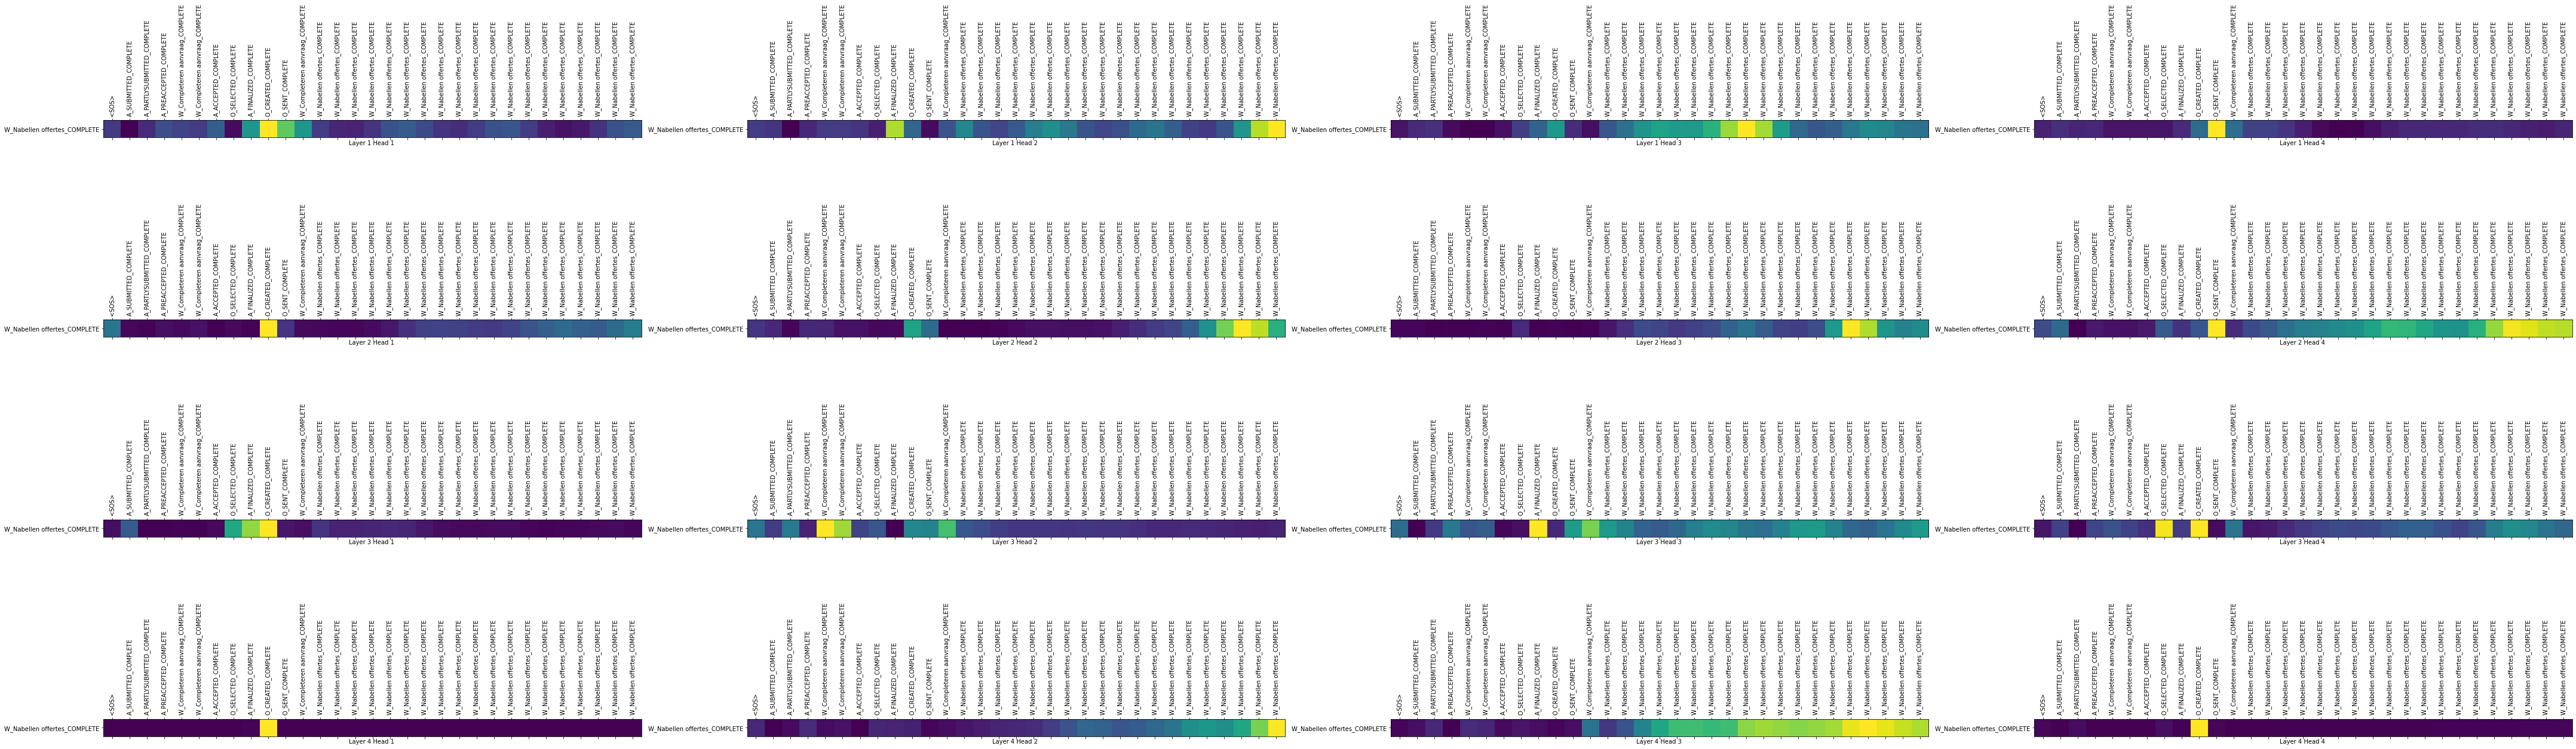

In [11]:
model.plot_step_attention_weight(24, all_predicted_tokens, attentions_in_time_series, example_activities_input.shape[1])

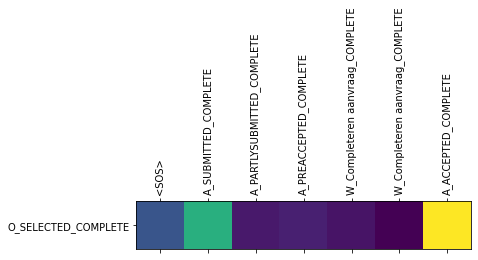

In [12]:
model.plot_stop_mean_attention_weight(0, all_predicted_tokens, attentions_in_time_series, example_activities_input.shape[1])

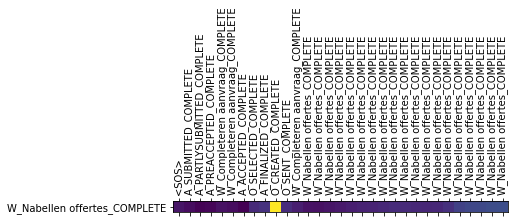

In [13]:
model.plot_stop_mean_attention_weight(24, all_predicted_tokens, attentions_in_time_series, example_activities_input.shape[1])